### Full Name : Tina Halimi
### Student Number : 400101078


# CART Algorithm Implementation with MNIST Dataset

## Goal
The objective is to implement the Classification and Regression Trees (CART) algorithm from scratch and apply it to the MNIST dataset. After completing the implementation, you will compare its performance with scikit-learn's `DecisionTreeClassifier` and analyze the results through visualizations.

## Part 1: Data Preparation and Exploration

1. **Data Normalization**  
   - Normalize the data using **z-score normalization** to ensure that each feature has a mean of 0 and a standard deviation of 1.

2. **Data Visualization**
   a. Display 10 sample images from the **training set**, **validation set**, and **test set**.  
   b. Create a **histogram** showing the distribution of labels across the **training set**, **validation set**, and **test set**.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

def prepare_data(batch_size=64, train_ratio=0.8):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # mean and std of mnist dataset
    ])

    full_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)

    train_size = int(len(full_dataset) * train_ratio)
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [2]:
import matplotlib.pyplot as plt

def explore_data(data_loader):

    images, labels = next(iter(data_loader))

    fig, axes = plt.subplots(1, 10, figsize=(15, 5))
    for i in range(10):
        axes[i].imshow(images[i].numpy().squeeze(), cmap='gray')
        axes[i].set_title(labels[i].item())
        axes[i].axis('off')
    plt.show()

    # Plot label distribution
    labels_list = [label.item() for label in labels]
    plt.figure(figsize=(10, 6))
    plt.hist(labels_list, bins=np.arange(11) - 0.5, edgecolor='black')
    plt.xticks(np.arange(10))
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title('Label Distribution')
    plt.show()


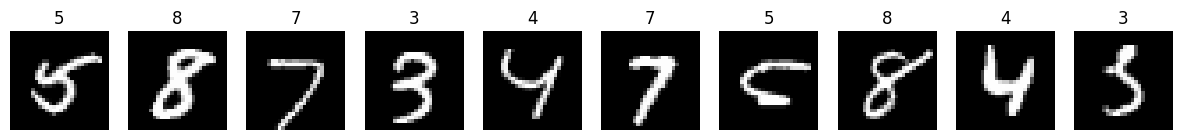

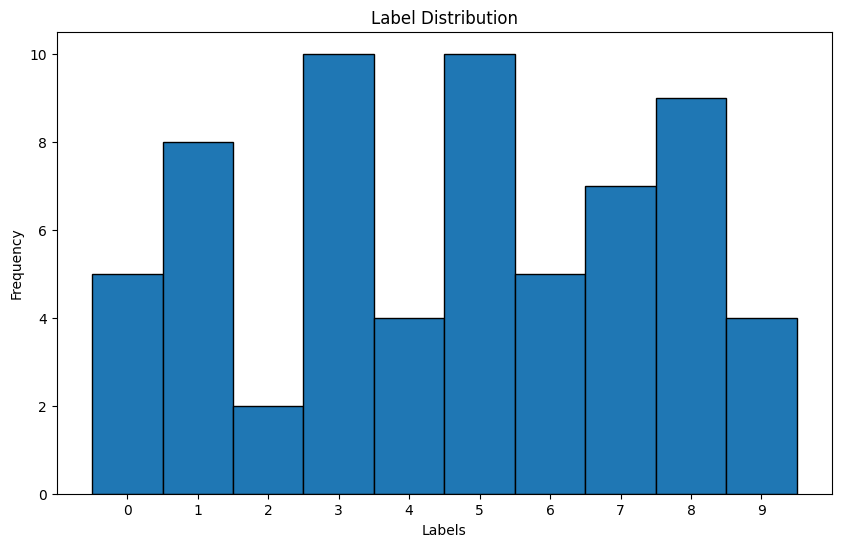

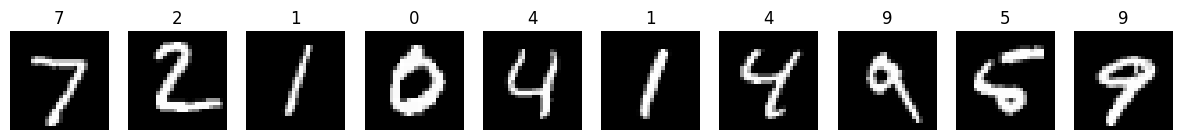

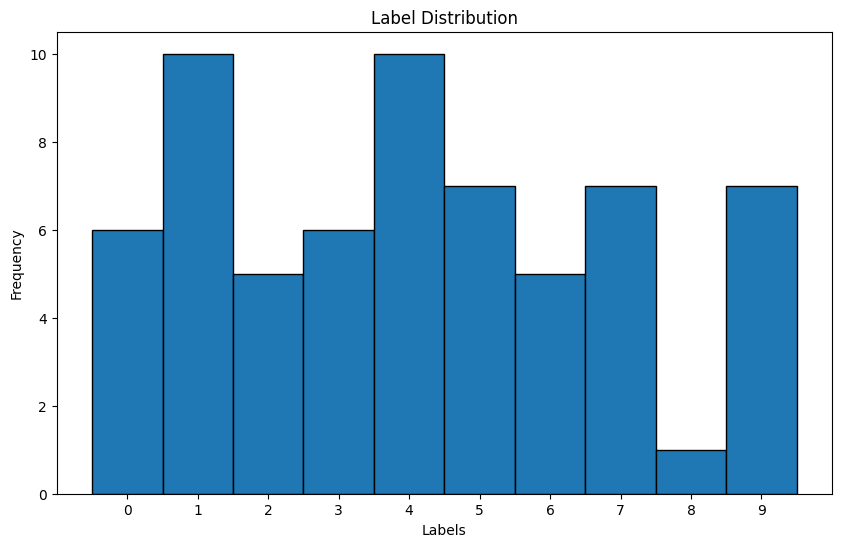

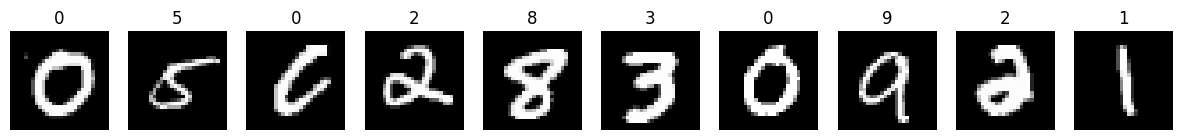

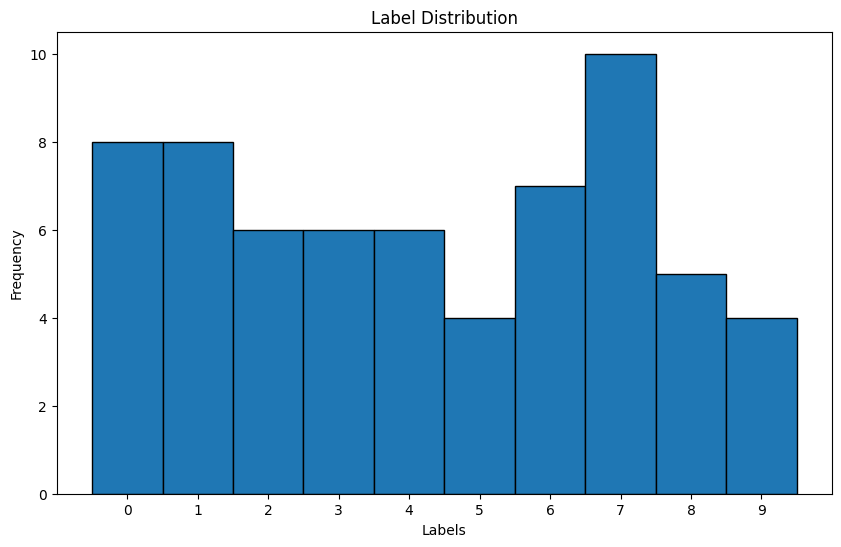

In [3]:
train_loader, val_loader, test_loader = prepare_data()
explore_data(train_loader)
explore_data(test_loader)
explore_data(val_loader)


Prepare the data for use with the CART algorithm by flattening the images.

In [4]:
def prepare_data_for_cart(data_loader):
    flattened_images = []
    labels_list = []

    for images, labels in data_loader:
        images = images.view(images.size(0), -1)  # Flattening the images
        flattened_images.append(images)
        labels_list.append(labels)

    # Concatenate all batches into a single tensor
    flattened_images = torch.cat(flattened_images)
    labels_list = torch.cat(labels_list)
    return flattened_images.numpy(), labels_list.numpy()

In [5]:
X_train, y_train = prepare_data_for_cart(train_loader)
X_val, y_val = prepare_data_for_cart(val_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

## Part 2: CART Algorithm Implementation

1. Implement the CART algorithm from scratch, including:
   a. Node class to represent tree nodes
   b. DecisionTree class with the following methods:
      - `fit(X, y)`: Train the decision tree
      - `predict(X)`: Make predictions on new data
      - `_build_tree(X, y, depth)`: Recursively build the tree
      - `_find_best_split(X, y)`: Find the best feature and threshold for splitting
      - `_calculate_gini_impurity(y)`: Calculate Gini impurity for a set of labels
2. Your implementation should support the following hyperparameters:
   - `max_depth`: Maximum depth of the tree
   - `min_samples_split`: Minimum number of samples required to split an internal node

Note: Feel free to change, add, and remove functions.

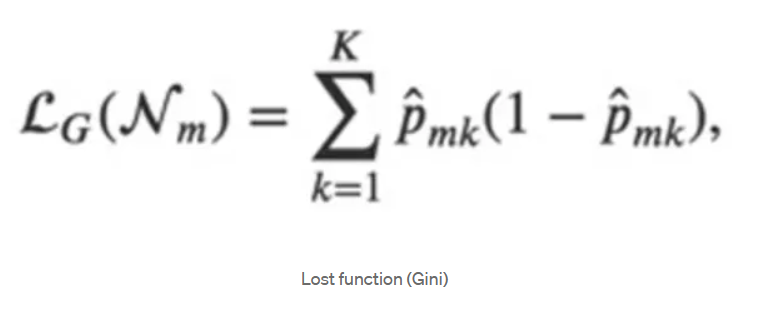

In [6]:
import numpy as np

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value


class DecisionTree_CART:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        if depth >= self.max_depth or num_samples < self.min_samples_split or len(set(y)) == 1:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        best_feature, best_threshold = self._find_best_split(X, y)

        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left = self._build_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._build_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)

    def _find_best_split(self, X, y):
        num_samples, num_features = X.shape
        best_gini = 1.0
        best_feature, best_threshold = None, None

        for feature in range(num_features):
            feature_values = X[:, feature]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                left_idxs, right_idxs = self._split(feature_values, threshold)
                if len(left_idxs) == 0 or len(right_idxs) == 0:
                    continue

                gini = self._calculate_gini_impurity(y[left_idxs], y[right_idxs])
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_gini_impurity(self, left_y, right_y):
        def gini(y):
            m = len(y)
            if m == 0:
                return 0
            class_probs = [np.sum(y == c) / m for c in np.unique(y)]
            return 1.0 - sum([p ** 2 for p in class_probs])
        num_left = len(left_y)
        num_right = len(right_y)
        total_samples = num_left + num_right

        gini_left = gini(left_y)
        gini_right = gini(right_y)

        weighted_gini = (num_left / total_samples) * gini_left + (num_right / total_samples) * gini_right
        return weighted_gini

    def _split(self, feature_values, threshold):
        left_idxs = np.argwhere(feature_values <= threshold).flatten()
        right_idxs = np.argwhere(feature_values > threshold).flatten()
        return left_idxs, right_idxs

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)


## Part 3: Model Evaluation and Comparison

1. Train your CART implementation on the MNIST training data.
2. Evaluate your model's performance on the test set and report the accuracy.
3. Train scikit-learn's DecisionTreeClassifier on the same data.
4. Compare the performance of your implementation with scikit-learn's version.
5. Create a plot showing how accuracy changes with tree depth for both implementations.

In [8]:
from sklearn.metrics import accuracy_score

X_train, y_train = prepare_data_for_cart(train_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

tree = DecisionTree_CART(max_depth=4)
tree.fit(X_train, y_train)

predictions = tree.predict(X_test)


accuracy = accuracy_score(y_test, predictions)
print(f"CART Accuracy on test set: {accuracy:.4f}")


CART Accuracy on test set: 0.5959


In [9]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X_train, y_train)

sklearn_predictions = clf.predict(X_test)

sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)
print(f"scikit-learn DecisionTree Accuracy on test set: {sklearn_accuracy:.4f}")


scikit-learn DecisionTree Accuracy on test set: 0.5959


The CART implementation and the scikit-learn has the same perfomance. 

Depth: 2 | CART Accuracy: 0.3447 | scikit-learn Accuracy: 0.3447
Depth: 3 | CART Accuracy: 0.4901 | scikit-learn Accuracy: 0.4901
Depth: 4 | CART Accuracy: 0.5959 | scikit-learn Accuracy: 0.5959
Depth: 5 | CART Accuracy: 0.6771 | scikit-learn Accuracy: 0.6771
Depth: 6 | CART Accuracy: 0.7484 | scikit-learn Accuracy: 0.7482
Depth: 7 | CART Accuracy: 0.7897 | scikit-learn Accuracy: 0.7897


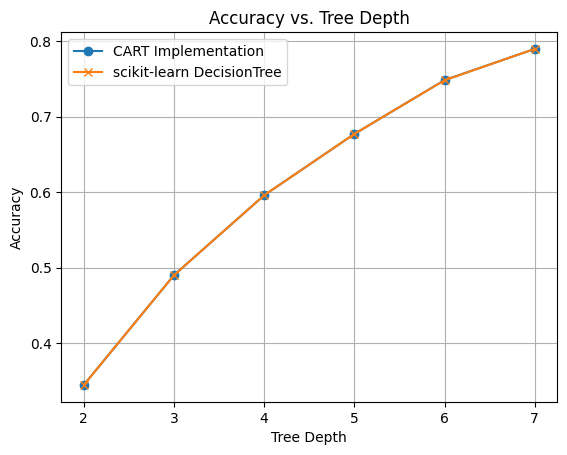

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


X_train, y_train = prepare_data_for_cart(train_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

depths = list(range(2, 8))
cart_accuracies = []
sklearn_accuracies = []

for depth in depths:

    tree = DecisionTree_CART(max_depth=depth)
    tree.fit(X_train, y_train)
    cart_predictions = tree.predict(X_test)
    cart_accuracy = accuracy_score(y_test, cart_predictions)
    cart_accuracies.append(cart_accuracy)

    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)
    sklearn_predictions = clf.predict(X_test)
    sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)
    sklearn_accuracies.append(sklearn_accuracy)

    print(f"Depth: {depth} | CART Accuracy: {cart_accuracy:.4f} | scikit-learn Accuracy: {sklearn_accuracy:.4f}")

# Plot the accuracy vs. tree depth for both models
plt.plot(depths, cart_accuracies, label="CART Implementation", marker='o')
plt.plot(depths, sklearn_accuracies, label="scikit-learn DecisionTree", marker='x')
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Tree Depth")
plt.legend()
plt.grid(True)
plt.show()


## Question
What is the difference between ID3 and CART algorithm

The **ID3 (Iterative Dichotomiser 3)** algorithm and the **CART (Classification and Regression Trees)** algorithm are both decision tree algorithms, but they differ in several key ways:

### 1. **Criterion for Splitting**:
   - **ID3**: Uses **information gain** based on entropy to decide the best feature to split on at each node. It aims to maximize the reduction in entropy after each split, preferring features that provide the most information about the classification.
   - **CART**: Uses **Gini impurity** for classification trees (and sometimes other criteria like mean squared error for regression trees) to decide the best feature to split on. It aims to minimize the Gini impurity after each split.

### 2. **Output**:
   - **ID3**: Primarily designed for **classification** problems and produces a **classification tree**.
   - **CART**: Can handle both **classification and regression** tasks, producing either a **classification tree** (for discrete outputs) or a **regression tree** (for continuous outputs).

### 3. **Handling of Continuous Features**:
   - **ID3**: Handles only **categorical features** by default. For continuous features, they need to be discretized before being used in the ID3 algorithm.
   - **CART**: Handles both **continuous** and **categorical features** natively, splitting on numerical values as needed.

### 4. **Tree Structure**:
   - **ID3**: The tree generated by ID3 has **multi-way splits** based on the number of distinct values of the feature (each feature split can result in more than two branches).
   - **CART**: The tree generated by CART is a **binary tree**, meaning each internal node always has exactly two branches.

### 5. **Pruning**:
   - **ID3**: Does not inherently involve pruning, though variants like C4.5 (which is an extension of ID3) include pruning techniques.
   - **CART**: Typically involves **pruning** after the tree is constructed to prevent overfitting and improve generalization.